**Part 2. AI Agent ÌôúÏö© ÌîÑÎ°úÏ†ùÌä∏**

- Chapter 03. NÍ∞ú Ïù¥ÏÉÅÏùò Agent

    - **üìí[Ïã§Ïäµ]** Clip 03. Network - Í≤ÄÏÉâ Í≤∞Í≥ºÎ•º Ï∞®Ìä∏Î°ú Í∑∏Î†§Ï£ºÎäî AgentüóíÔ∏è

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")

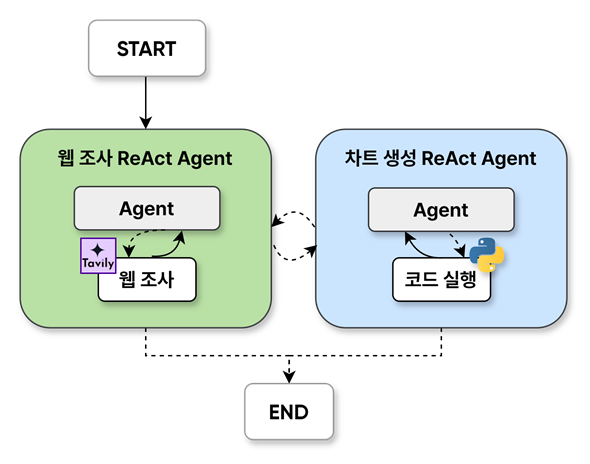

- Í≥µÏö© ÏãúÏä§ÌÖú ÌîÑÎ°¨ÌîÑÌä∏

In [2]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

### Í≤ÄÏÉâÏùÑ Í∏∞Î∞òÏúºÎ°ú Ï°∞ÏÇ¨ÌïòÎäî Agent

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [4]:
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent

llm = ChatAnthropic(model="claude-3-7-sonnet-20250219")

research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [5]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, END
from langgraph.types import Command


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto


def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator") # END or "chart_generator"

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )


### Ï∞®Ìä∏Î•º ÏÉùÏÑ±ÌïòÎäî Agent

In [6]:
from typing import Annotated
from langchain_core.tools import tool


@tool
def python_exec_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = exec(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [7]:
chart_agent = create_react_agent(
    llm,
    [python_exec_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [8]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

In [9]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("researcher", research_node)
graph_builder.add_node("chart_generator", chart_node)

graph_builder.add_edge(START, "researcher")
graph = graph_builder.compile()

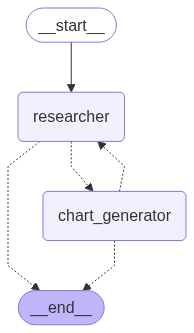

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

ÌÖåÏä§Ìä∏ !

{'researcher': {'messages': [HumanMessage(content='2020ÎÖÑ ÌïúÍµ≠Ïùò ÏΩîÎ°úÎÇò 19 ÌôïÏßÑÏûê ÏàòÎ•º Ï°∞ÏÇ¨ÌïòÏó¨, Ïù¥Î•º Ï∞®Ìä∏Î°ú ÎßåÎì§Ïñ¥Ï£ºÏÑ∏Ïöî. ÎàÑÏ†ÅÌôïÏßÑÏûêÏôÄ Ïã†Í∑úÌôïÏßÑÏûêÍ∞Ä Î™®Îëê Ìè¨Ìï®ÎêòÏñ¥Ïïº Ìï©ÎãàÎã§.Ï∞®Ìä∏ ÏÜç Í∏ÄÏî®Îäî ÏòÅÏñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî.Ï∞®Ìä∏Î•º ÎßåÎì§Í≥† ÎÇòÎ©¥ ÎÅùÎÇ¥ÏÑ∏Ïöî.', additional_kwargs={}, response_metadata={}, id='b6d46678-6762-4347-98ba-7c19b06b7f3f'), AIMessage(content=[{'text': "I'll help you research the COVID-19 cases in South Korea during 2020, including both cumulative and new cases. This information will be useful for creating a chart later.", 'type': 'text'}, {'id': 'toolu_011ChojRxNrPJ8mbYEp1hVSD', 'input': {'query': 'South Korea COVID-19 cases data 2020 cumulative and new daily cases statistics'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Hpq2yJn44ReF6kx87L7tcv', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'

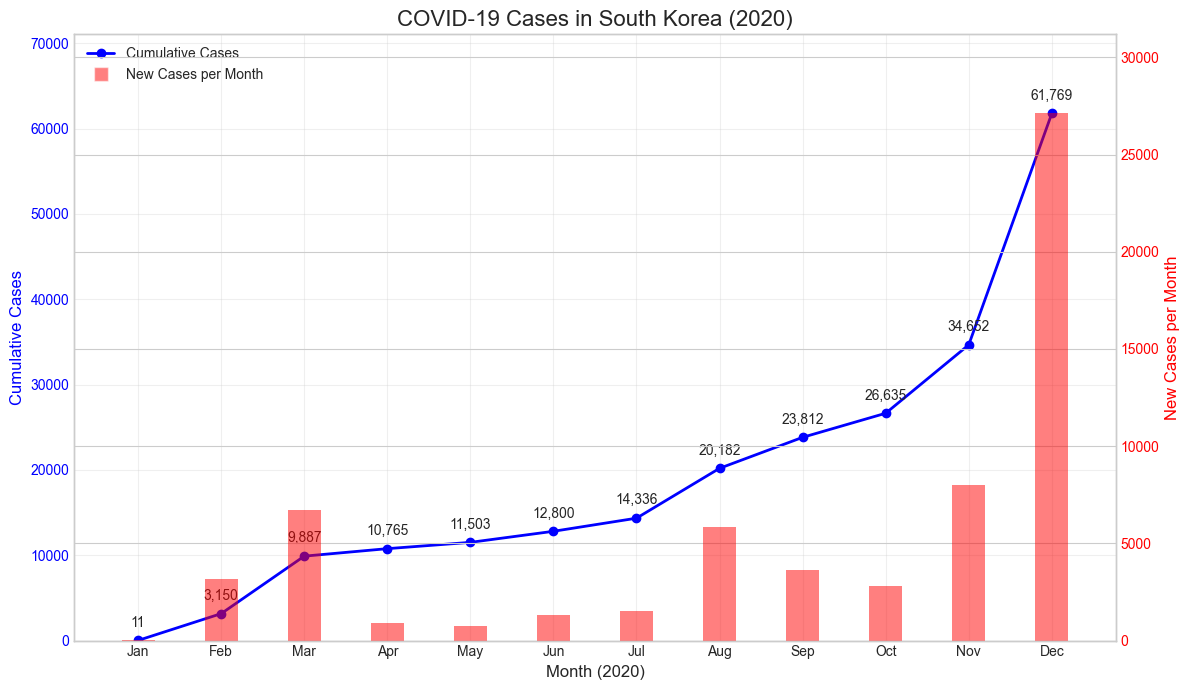

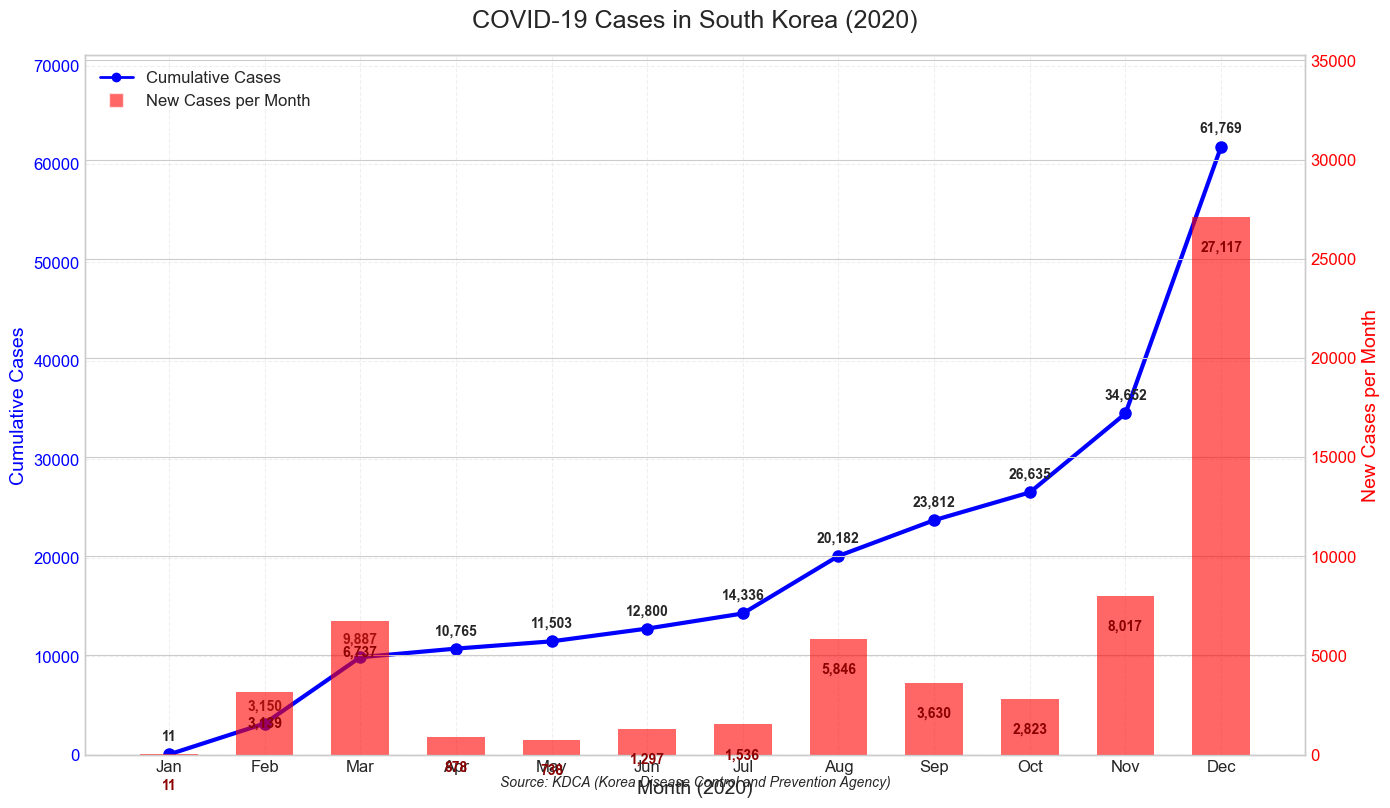

{'chart_generator': {'messages': [HumanMessage(content='2020ÎÖÑ ÌïúÍµ≠Ïùò ÏΩîÎ°úÎÇò 19 ÌôïÏßÑÏûê ÏàòÎ•º Ï°∞ÏÇ¨ÌïòÏó¨, Ïù¥Î•º Ï∞®Ìä∏Î°ú ÎßåÎì§Ïñ¥Ï£ºÏÑ∏Ïöî. ÎàÑÏ†ÅÌôïÏßÑÏûêÏôÄ Ïã†Í∑úÌôïÏßÑÏûêÍ∞Ä Î™®Îëê Ìè¨Ìï®ÎêòÏñ¥Ïïº Ìï©ÎãàÎã§.Ï∞®Ìä∏ ÏÜç Í∏ÄÏî®Îäî ÏòÅÏñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî.Ï∞®Ìä∏Î•º ÎßåÎì§Í≥† ÎÇòÎ©¥ ÎÅùÎÇ¥ÏÑ∏Ïöî.', additional_kwargs={}, response_metadata={}, id='b6d46678-6762-4347-98ba-7c19b06b7f3f'), AIMessage(content=[{'text': "I'll help you research the COVID-19 cases in South Korea during 2020, including both cumulative and new cases. This information will be useful for creating a chart later.", 'type': 'text'}, {'id': 'toolu_011ChojRxNrPJ8mbYEp1hVSD', 'input': {'query': 'South Korea COVID-19 cases data 2020 cumulative and new daily cases statistics'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Hpq2yJn44ReF6kx87L7tcv', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "2020ÎÖÑ ÌïúÍµ≠Ïùò ÏΩîÎ°úÎÇò 19 ÌôïÏßÑÏûê ÏàòÎ•º Ï°∞ÏÇ¨ÌïòÏó¨, Ïù¥Î•º Ï∞®Ìä∏Î°ú ÎßåÎì§Ïñ¥Ï£ºÏÑ∏Ïöî. ÎàÑÏ†ÅÌôïÏßÑÏûêÏôÄ Ïã†Í∑úÌôïÏßÑÏûêÍ∞Ä Î™®Îëê Ìè¨Ìï®ÎêòÏñ¥Ïïº Ìï©ÎãàÎã§."
                "Ï∞®Ìä∏ ÏÜç Í∏ÄÏî®Îäî ÏòÅÏñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî."
                "Ï∞®Ìä∏Î•º ÎßåÎì§Í≥† ÎÇòÎ©¥ ÎÅùÎÇ¥ÏÑ∏Ïöî.",
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='Î®ºÏ†Ä, ÏßÄÎÇú 2020ÎÖÑ ~ 2024ÎÖÑÏùò ÌïúÍµ≠Ïùò GDPÎ•º Íµ¨Ìïú Îã§Ïùå, Ïù¥Î•º Î∞îÌÉïÏúºÎ°ú ÏÑ†Ìòï Ï∞®Ìä∏Î•º ÎßåÎìúÏÑ∏Ïöî. Ï∞®Ìä∏ ÏÜç Í∏ÄÏî®Îäî ÏòÅÏñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî.Ï∞®Ìä∏Î•º ÎßåÎì§Í≥† ÎÇòÎ©¥ ÎÅùÎÇ¥ÏÑ∏Ïöî.', additional_kwargs={}, response_metadata={}, id='096a668c-abf2-4b63-8452-ca73d55069a4'), AIMessage(content=[{'text': "I'll search for the GDP data of South Korea from 2020 to 2024. Let me gather this information.", 'type': 'text'}, {'id': 'toolu_01QPgufrv9bXQ94f8YVERH25', 'input': {'query': 'South Korea GDP data 2020 2021 2022 2023 2024 annual figures'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UUTkP8tmKTs5fknqmY7ESa', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 617, 'output_tokens': 106}, 'model_name': 'claude-3-7-sonnet-20250

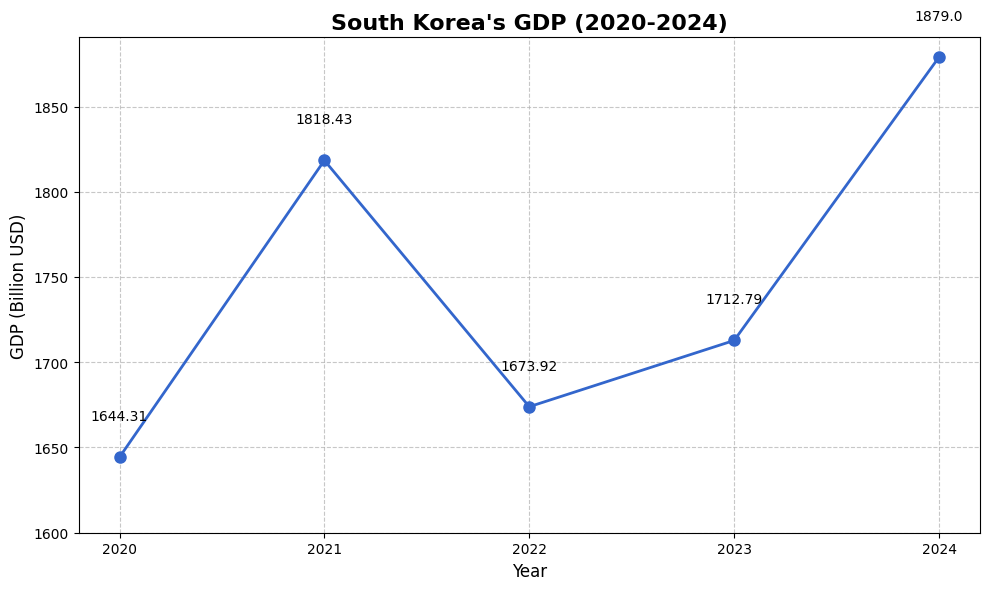

{'chart_generator': {'messages': [HumanMessage(content='Î®ºÏ†Ä, ÏßÄÎÇú 2020ÎÖÑ ~ 2024ÎÖÑÏùò ÌïúÍµ≠Ïùò GDPÎ•º Íµ¨Ìïú Îã§Ïùå, Ïù¥Î•º Î∞îÌÉïÏúºÎ°ú ÏÑ†Ìòï Ï∞®Ìä∏Î•º ÎßåÎìúÏÑ∏Ïöî. Ï∞®Ìä∏ ÏÜç Í∏ÄÏî®Îäî ÏòÅÏñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî.Ï∞®Ìä∏Î•º ÎßåÎì§Í≥† ÎÇòÎ©¥ ÎÅùÎÇ¥ÏÑ∏Ïöî.', additional_kwargs={}, response_metadata={}, id='096a668c-abf2-4b63-8452-ca73d55069a4'), AIMessage(content=[{'text': "I'll search for the GDP data of South Korea from 2020 to 2024. Let me gather this information.", 'type': 'text'}, {'id': 'toolu_01QPgufrv9bXQ94f8YVERH25', 'input': {'query': 'South Korea GDP data 2020 2021 2022 2023 2024 annual figures'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UUTkP8tmKTs5fknqmY7ESa', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 617, 'output_tokens': 106}, 'model_name': 'claude-3-7-sonnet-

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Î®ºÏ†Ä, ÏßÄÎÇú 2020ÎÖÑ ~ 2024ÎÖÑÏùò ÌïúÍµ≠Ïùò GDPÎ•º Íµ¨Ìïú Îã§Ïùå, Ïù¥Î•º Î∞îÌÉïÏúºÎ°ú ÏÑ†Ìòï Ï∞®Ìä∏Î•º ÎßåÎìúÏÑ∏Ïöî. Ï∞®Ìä∏ ÏÜç Í∏ÄÏî®Îäî ÏòÅÏñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî."
                "Ï∞®Ìä∏Î•º ÎßåÎì§Í≥† ÎÇòÎ©¥ ÎÅùÎÇ¥ÏÑ∏Ïöî.",
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")